### Версия Python

In [1]:
!python -V

Python 3.12.5


### Импорт необходимых библиотек

In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import re
import glob
import json
import qbstyles
import pandas as pd
import bs4
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import jupyterlab as jlab
import tqdm as tq

from qbstyles import mpl_style
from pathlib import Path
from bs4 import BeautifulSoup
from tqdm import tqdm

mpl_style(dark = False)

In [3]:
path_to_files = "/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/ПУДы"

xlsx_files = glob.glob(os.path.join(path_to_files, "*.xlsx"))

df = pd.DataFrame()

for file in xlsx_files:
    df_temp = pd.read_excel(file)
    df = pd.concat([df, df_temp], ignore_index = True)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Подготовка данных
vacancy_description = "Инженер по наладке и испытаниям. Обязанности:  Выполняет работу по наладке и испытаниям выпускаемых изделий в соответствии с методиками и др.руководящими документами по организации пусконаладочных работ, обеспечивает его своевременный ввод в эксплуатацию. Осуществляет подготовку к работе средств измерений и аппаратуры, осуществляет замеры необходимых параметров. Проводит наладку и испытания изделий по методикам на соответствие техн.условиям на них. Участвует в ремонтно-восстановительных работах испытательного и цехового имущества, касающегося как механической, так электр.части. Предоставляет информацию о дефектах, отказах и неисправностях в процессе сдачи изделия на объекте.  Требования:  Ответственность, целеустремленность, организованность, пунктуальность, умение работать с измерительной техникой, нормативной и технической документацией, знание английского приветствуется.  Условия:  Постоянная. Пятидневная рабочая неделя. с 8.00ч. до 17.00 ч. Сб и Вс- выходной. Предусмотрены плановые поездки в командировки в места строительства и ремонта кораблей. Размер заработной платы обсуждается на собеседовании в соответствии с квалификацией и опытом работы. Соц.пакет. Начинающим иногородним специалистам оплачивается частично найм жилья. Пользователь ПК, Работа в команде, Английский язык. Инженер-конструктор, инженер-проектировщик."

# df_cleaned = df.drop_duplicates(subset = ['Русскоязычное название дисциплины', 'Факультет кафедры, предлагающей дисциплину'])

# # Затем группируем по "Факультет кафедры, предлагающей дисциплину" и собираем дисциплины в список
# grouped_df = df_cleaned.groupby('Факультет кафедры, предлагающей дисциплину')['Русскоязычное название дисциплины'].apply(list).reset_index()



# Создаем новый DataFrame на основе df, чтобы избежать возможных проблем с копиями
df_cleaned = df.drop_duplicates(subset=['Русскоязычное название дисциплины', 'Факультет кафедры, предлагающей дисциплину']).copy()

# Объединяем нужные столбцы в один текст для каждой строки с использованием .loc
df_cleaned.loc[:, 'Full_Info'] = (
    df_cleaned['Русскоязычное название дисциплины'] + 
    '\nАннотация: ' + df_cleaned['Аннотация'].fillna('') +
    '\nСписок разделов: ' + df_cleaned['Список разделов (названия и описания)'].fillna('') +
    '\nСписок планируемых результатов обучения: ' + df_cleaned['Список планируемых результатов обучения РПУДа'].fillna('')
)

# Группируем по факультету и собираем объединенные тексты в список
grouped_df = df_cleaned.groupby('Факультет кафедры, предлагающей дисциплину')['Full_Info'].apply(list).reset_index()



for i in range(len(grouped_df)):
    # Теперь grouped_df будет содержать факультеты и список уникальных дисциплин для каждого из них
    # print(grouped_df.iloc[num]['Факультет кафедры, предлагающей дисциплину'])
    subjects_descriptions = grouped_df.iloc[i]['Full_Info']

    # subjects_descriptions = ['Современное искусство в России', 'Профессии в арт-мире', 'Выставочная деятельность', 'Особенности исследования в современном искусстве', 'Управление выставочными проектами', 'Анализ и интерпретации современного искусства: модели и инструментарий', 'Издательское дело в выставочном процессе', 'Современная критика', 'История медиа – история современного искусства', 'Логистика и таможенные режимы', 'Хранение произведений современного искусства', 'Научно-исследовательский семинар "Планирование и этапы подготовки выставки"', 'Современное искусство. Введение', 'История музейно-выставочного дела', 'Теория и история культуры', 'Специфика визуального восприятия современного искусства', 'Семинар наставника «Планирование и этапы подготовки выставки»', 'Музей как политический, экономический, социальный институт', 'Семинар наставника «Планирование и этапы подготовки культурного проекта»', 'Программное планирование', 'Теория и история искусства', 'Управление проектами в сфере культуры', 'Транспортировка и хранение произведений современного искусства', 'Сензитивность и инклюзия', 'Стратегический менеджмент\t', 'Маркетинг и продвижение проектов в сфере культуры', 'Эволюция художественной критики']
    
    # 2. Применение TF-IDF
    corpus = [vacancy_description] + subjects_descriptions  # Объединяем тексты вакансии и предметов в один корпус
    vectorizer = TfidfVectorizer()  # Создаем объект TF-IDF Vectorizer
    tfidf_matrix = vectorizer.fit_transform(corpus)  # Применяем TF-IDF преобразование
    
    # 3. Рассчитываем косинусное сходство
    vacancy_vector = tfidf_matrix[0]  # Вектор вакансии
    subjects_vectors = tfidf_matrix[1:]  # Векторы предметов
    
    cosine_similarities = cosine_similarity(vacancy_vector, subjects_vectors).flatten()
    
    # 4. Вывод результатов
    # for idx, similarity in enumerate(cosine_similarities):
    #     print(f"Similarity with subject '{subjects_descriptions[idx]}': {similarity:.4f}")
    
    # Определение наиболее релевантного предмета
    most_similar_idx = np.argmax(cosine_similarities)

    # 4. Находим три самых релевантных предмета
    top_n = 3  # Число топовых предметов для выбора
    top_indices = cosine_similarities.argsort()[-top_n:][::-1]  # Индексы топ-3 предметов

    for idx in top_indices:
        if cosine_similarities[idx] > 0:
            full_info = subjects_descriptions[idx]
            discipline_name = full_info.split('\n')[0]
            print(f"{grouped_df.iloc[i]['Факультет кафедры, предлагающей дисциплину']} -- '{discipline_name}': {cosine_similarities[idx]:.4f}")

Базовая кафедра Музея современного искусства "Гараж" -- 'Анализ и интерпретации современного искусства: модели и инструментарий': 0.0537
Базовая кафедра Музея современного искусства "Гараж" -- 'Современное искусство в России': 0.0487
Базовая кафедра Музея современного искусства "Гараж" -- 'Профессии в арт-мире': 0.0468
Базовые кафедры -- 'Управленческое консультирование для решения бизнес-задач: базовые навыки, отраслевая, функциональная экспертиза и цифровизация': 0.0360
Базовые кафедры -- 'GR в современной России: теория и практика': 0.0210
Базовые кафедры -- 'Управленческое консультирование для решения бизнес-задач: базовые навыки и функциональная экспертиза': 0.0136
Банковский институт -- 'Международный валютный рынок': 0.0923
Банковский институт -- 'Построение финансовых моделей на практике': 0.0839
Банковский институт -- 'Прогнозирование на финансовых рынках': 0.0336
Вечерне-заочный факультет экономики и управления -- 'Английский язык': 0.0963
Вечерне-заочный факультет экономики 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Определение пути к папке с CSV файлами
path_to_files = Path("/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/Вакансии_обработанные_фильтр_5000")

# Функция для извлечения числа из имени файла
def extract_number(path):
    match = re.search(r'part_(\d+)', path.name)
    return int(match.group(1)) if match else 0

# Сортировка списка путей по числам в имени файла
csv_files = sorted(list(path_to_files.rglob("*.csv")), key = extract_number)

# Подсчет общего количества строк во всех файлах
total_rows = 0
for file_path in csv_files:
    try:
        df_e = pd.read_csv(file_path, sep = ";", on_bad_lines = "skip")
        total_rows += len(df_e)
    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {e}")

# Удаляем дубликаты и объединяем текстовые столбцы
df_cleaned = df.drop_duplicates(subset=['Русскоязычное название дисциплины', 'Факультет кафедры, предлагающей дисциплину']).copy()
df_cleaned['Full_Info'] = (
    df_cleaned['Русскоязычное название дисциплины'] + 
    '\nАннотация: ' + df_cleaned['Аннотация'].fillna('') +
    '\nСписок разделов: ' + df_cleaned['Список разделов (названия и описания)'].fillna('') +
    '\nСписок планируемых результатов обучения: ' + df_cleaned['Список планируемых результатов обучения РПУДа'].fillna('')
)

# Группируем по факультету и собираем объединенные тексты в список
grouped_df = df_cleaned.groupby('Факультет кафедры, предлагающей дисциплину')['Full_Info'].apply(list).reset_index()

# Инициализация общего прогресс-бара
with tqdm(total = total_rows, desc = "Общий прогресс обработки", unit = "строка") as pbar:
    for file_path in csv_files:
        df_e = pd.read_csv(file_path, sep = ";")

        idx = 0
        
        # Проход по каждой строке DataFrame
        for index, row in df_e.iterrows():
            # Проверяем, заполнена ли колонка 'Subjects' для текущей строки
            if 'Subjects' in df_e.columns and isinstance(row['Subjects'], str) and row['Subjects'].strip():
                pass
            else:
                columns_name = df_e.columns
    
                parts = []
        
                for col in columns_name[0], columns_name[1], columns_name[2], columns_name[3]:
                    value = row[col]
                    # Добавляем в parts только если value не NaN и является строкой
                    if isinstance(value, str) and value.strip():
                        parts.append(value)
                
                vacancy_description = ". ".join(parts).strip()
    
                # Подготовка данных
                # vacancy_description = "Senior .Net разработчик. Гольфстрим - российская компания, часть экосистемы МТС, лидер на рынке охранных услуг для частных и бизнес-объектов недвижимости. Сегодня мы работаем более чем в 200 городах России, предоставляем решения по безопасности для 85 тыс. домохозяйств, TOП 10 банков России и 25% российского рынка розничных сетей. В 2022 мы стали частью компании МТС. Чем предстоит заниматься:  Оценка трудоемкости задач; Написание кода и unit-тестов; Code review, менторство; Оптимизация производительности кода; Участие в устранении инцидентов в качестве 3-ей линии поддержки; Участие в публикации решений совместно с DevOps.  Что мы ждем от кандидата:  Опыт разработки на языке C# под платформу .NET (версия 5 и выше) от 4-х лет; Опыт применения в реальных проектах ASP.NET (Web API), LINQ, ORM (EF / NHibernate / Dapper), библиотек для маппинга (AutoMapper / Mapster), планировщиков заданий (Quartz / Hangfire), библиотек для unit-тестирования (NUnit / xUnit / Nsubstitute / Moq), Polly, FluentValidation, MediatR, Microsoft.DI; Глубокие знания в части многопоточности в .NET; Опыт в разработке API (REST / SOAP / gRPC); Опыт разработки общих библиотек и их документирования; Реальное понимание принципов SOLID, DRY, KISS и умение применять их в своих решениях; Опыт разработки продуктов в микросервисной архитектуре; Опыт разработки БД в MS SQL Server (таблицы, индексирование); Знание TSQL на уровне написания сложных запросов (фильтрация, join, агрегирование, группировки, оконные функции, подзапросы, CTE, использование XML/JSON); Опыт работы с брокерами сообщений (RabbitMq, Kafka); Навыки работы с Git; Опыт разработки приложений под Docker.  Что мы предлагаем:  Трудоустройство в IT-аккредитованную компанию; Работа в компании с 30-летней историей. Гольфстрим — бренд № 1 на рынке безопасности в стране; Развитие нон-стоп: для всех сотрудников доступен Корпоративный университет, а в компании есть все возможности для карьерного роста;   Корпоративная библиотека Alpina Digital: полная коллекция книг, аудиокниг, саммари, видео, тестов по бизнесу и саморазвитию на русском языке BestBenefits — сервис предложений и скидок для работников, который предлагает уникальные условия по разным направлениям. Можно купить со скидкой абонемент в фитнес-клуб, получить специальные условия при посещении кафе и ресторанов, скидки на технику, товары для дома, детские и медицинские товары; Офисный формат работы или полностью удаленно; Предоставляем современное оборудование; Отсутствие дресс-кода; Офис в пяти минутах от метро Дмитровская. MS SQL, ASP.NET, Разработка ПО, Git, Docker. Программист, разработчик. "
                
                # Устанавливаем порог для косинусного сходства
                threshold = 0.1
                
                # Инициализируем список для хранения результатов
                results = []
                
                for i in range(len(grouped_df)):
                    # Получаем список описаний дисциплин для текущего факультета
                    subjects_descriptions = grouped_df.iloc[i]['Full_Info']
                    
                    # Применение TF-IDF
                    corpus = [vacancy_description] + subjects_descriptions
                    vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1, 1))
                    tfidf_matrix = vectorizer.fit_transform(corpus)
                    
                    # Рассчитываем косинусное сходство
                    vacancy_vector = tfidf_matrix[0]
                    subjects_vectors = tfidf_matrix[1:]
                    cosine_similarities = cosine_similarity(vacancy_vector, subjects_vectors).flatten()
                    
                    # Находим три самых релевантных предмета
                    top_n = 5
                    top_indices = np.argsort(cosine_similarities)[-top_n:][::-1]
                    
                    # Применяем порог и фильтруем индексы
                    top_indices = [idx for idx in top_indices if cosine_similarities[idx] > threshold]
                    
                    for idx in top_indices:
                        if cosine_similarities[idx] > 0:
                            full_info = subjects_descriptions[idx]
                            discipline_name = full_info.split('\n')[0]
                            results.append({
                                'Факультет': grouped_df.iloc[i]['Факультет кафедры, предлагающей дисциплину'],
                                'Дисциплина': discipline_name,
                                'Схожесть': cosine_similarities[idx]
                            })
                
                # Создаем DataFrame с результатами
                results_df = pd.DataFrame(results)
    
                try:
                    # Сортируем результаты по убыванию схожести
                    results_df = results_df.sort_values(by='Схожесть', ascending=False)
                except:
                    pass
                else:
                    # Объединяем столбцы 'Дисциплина' и 'Схожесть' через разделитель |
                    results_df['Дисциплина_Схожесть'] = results_df.apply(lambda row: f"{row['Дисциплина']} | {row['Факультет']}", axis=1)
                    
                    # Создаем список объединенных значений
                    combined_list = results_df['Дисциплина_Схожесть'].tolist()
                    
                    # Выводим результат
                    # print(combined_list)
                    
                    # Выводим результаты
                    # print(row[columns_name[0]] + " ------ ", "; ".join(combined_list))
        
                    # Добавление новых данных в DataFrame
                    df_e.at[index, "Subjects"] = "; ".join(combined_list)

                    idx += 1
                    
                    # Сохранение файла каждые N итераций
                    if idx % 3 == 0:
                        idx = 0
                        
                        df_e.to_csv(file_path, index = False, encoding = "utf-8-sig", sep = ";")
                    
            # Обновление общего прогресс-бара
            pbar.update(1)
        
        # Сохранение файла после обработки всех строк в нем
        df_e.to_csv(file_path, index = False, encoding = "utf-8-sig", sep = ";")

Общий прогресс обработки:   2%|▉                                      | 5555/236918 [11:45:43<462:03:25,  7.19s/строка]

In [8]:
3 % 3

0

### Версии необходимых библиотек

In [14]:
packages = [
    "Pandas", "Matplotlib", "Seaborn", "Qbstyles", "BeautifulSoup", "Tqdm", "JupyterLab"
]

package_objects = [
    pd, matplotlib, sns, qbstyles, bs4, tq, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

pkgs = {"Библиотека": packages, "Версия": versions}
df_pkgs = pd.DataFrame(data = pkgs)
df_pkgs.index.name = "№"
df_pkgs.index += 1

display(df_pkgs)

path_to_reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path_to_reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

,Библиотека,Версия
№,,
1,Pandas,2.2.2
2,Matplotlib,3.9.1
3,Seaborn,0.13.2
4,Qbstyles,0.1.4
5,BeautifulSoup,4.12.3
6,Tqdm,4.66.5
7,JupyterLab,4.2.4


### Предварительная обработка JSON файлов с вакансиями

In [54]:
skip_professional_roles = [
    # "BI-аналитик, аналитик данных",
    # "DevOps-инженер",
    # "Event-менеджер",
    # "PR-менеджер",
    # "SMM-менеджер, контент-менеджер",
    "Автомойщик",
    "Автослесарь, автомеханик",
    # "Агент по недвижимости",
    "Агроном",
    "Администратор",
    "Администратор магазина, администратор торгового зала",
    # "Аналитик",
    # "Андеррайтер",
    # "Арт-директор, креативный директор",
    "Артист, актер, аниматор",
    # "Архитектор",
    "Ассистент врача",
    # "Аудитор",
    # "Бизнес-аналитик",
    # "Бизнес-тренер",
    "Бортпроводник",
    # "Брокер",
    # "Бухгалтер",
    "Ветеринарный врач",
    # "Видеооператор, видеомонтажер",
    "Водитель",
    "Военнослужащий",
    "Воспитатель, няня",
    "Врач",
    # "Гейм-дизайнер",
    # "Генеральный директор, исполнительный директор (CEO)",
    "Геодезист",
    "Геолог",
    "Главный врач, заведующий отделением",
    # "Главный инженер проекта",
    "Грузчик",
    # "Дата-сайентист",
    "Дворник",
    # "Делопроизводитель, архивариус",
    # "Дизайнер, художник",
    "Директор магазина, директор сети магазинов",
    # "Директор по информационным технологиям (CIO)",
    # "Директор по маркетингу и PR (CMO)",
    # "Директор по персоналу (HRD)",
    # "Директор юридического департамента (CLO)",
    "Диспетчер",
    "Другое",
    # "Журналист, корреспондент",
    "Заведующий аптекой",
    "Зоотехник",
    # "Инженер ПНР",
    # "Инженер ПТО, инженер-сметчик",
    # "Инженер по качеству",
    # "Инженер по охране труда и технике безопасности, инженер-эколог",
    # "Инженер по эксплуатации",
    # "Инженер-конструктор, инженер-проектировщик",
    # "Инженер-электроник, инженер-электронщик",
    "Инженер-энергетик, инженер-электрик",
    "Казначей",
    "Кассир-операционист",
    "Кладовщик",
    # "Коммерческий директор (CCO)",
    # "Комплаенс-менеджер",
    "Контролёр ОТК",
    "Координатор отдела продаж",
    # "Копирайтер, редактор, корректор",
    "Косметолог",
    # "Кредитный специалист",
    "Курьер",
    "Лаборант",
    "Маляр, штукатур",
    # "Маркетолог-аналитик",
    "Массажист",
    "Мастер ногтевого сервиса",
    # "Мастер по ремонту оборудования, техники",
    "Мастер-приемщик",
    "Машинист",
    "Медицинская сестра, медицинский брат",
    "Медицинский представитель",
    # "Менеджер по закупкам",
    # "Менеджер по компенсациям и льготам",
    # "Менеджер по логистике, менеджер по ВЭД",
    # "Менеджер по маркетингу, интернет-маркетолог",
    # "Менеджер по персоналу",
    # "Менеджер по продажам, менеджер по работе с клиентами",
    # "Менеджер по работе с партнерами",
    # "Менеджер по туризму",
    # "Менеджер продукта",
    "Менеджер ресторана",
    # "Менеджер/консультант по стратегии",
    # "Менеджер/руководитель АХО",
    "Мерчандайзер",
    "Методист",
    "Методолог",
    "Метролог",
    "Механик",
    "Монтажник",
    # "Научный специалист, исследователь",
    # "Начальник производства",
    "Начальник склада",
    "Начальник смены, мастер участка",
    "Оператор call-центра, специалист контактного центра",
    # "Оператор ПК, оператор базы данных",
    # "Оператор производственной линии",
    "Оператор станков с ЧПУ",
    # "Операционный директор (COO)",
    "Офис-менеджер",
    "Официант, бармен, бариста",
    "Охранник",
    "Оценщик",
    "Парикмахер",
    # "Переводчик",
    "Повар, пекарь, кондитер",
    "Полицейский",
    # "Программист, разработчик",
    "Продавец-консультант, продавец-кассир",
    # "Продуктовый аналитик",
    "Продюсер",
    "Промоутер",
    "Прораб, мастер СМР",
    # "Психолог",
    "Разнорабочий",
    "Режиссер, сценарист",
    # "Руководитель группы разработки",
    # "Руководитель отдела аналитики",
    # "Руководитель отдела клиентского обслуживания",
    # "Руководитель отдела логистики",
    # "Руководитель отдела маркетинга и рекламы",
    # "Руководитель отдела персонала",
    # "Руководитель отдела продаж",
    # "Руководитель проектов",
    "Руководитель строительного проекта",
    # "Руководитель филиала",
    "Сварщик",
    "Секретарь, помощник руководителя, ассистент",
    # "Сервисный инженер, инженер-механик",
    # "Сетевой инженер",
    # "Системный администратор",
    # "Системный аналитик",
    # "Системный инженер",
    "Слесарь, сантехник",
    "Специалист по взысканию задолженности",
    # "Специалист по информационной безопасности",
    # "Специалист по кадрам",
    # "Специалист по подбору персонала",
    # "Специалист по сертификации",
    # "Специалист по тендерам",
    # "Специалист службы безопасности",
    # "Специалист технической поддержки",
    # "Страховой агент",
    "Супервайзер",
    # "Тестировщик",
    # "Технический директор (CTO)",
    # "Технический писатель",
    "Технолог",
    "Товаровед",
    "Токарь, фрезеровщик, шлифовщик",
    "Торговый представитель",
    "Уборщица, уборщик",
    "Упаковщик, комплектовщик",
    # "Учитель, преподаватель, педагог",
    "Фармацевт-провизор",
    # "Финансовый аналитик, инвестиционный аналитик",
    # "Финансовый директор (CFO)",
    # "Финансовый контролер",
    # "Финансовый менеджер",
    "Фитнес-тренер, инструктор тренажерного зала",
    "Фотограф, ретушер",
    "Хостес",
    "Швея, портной, закройщик",
    # "Экономист",
    "Электромонтажник",
    # "Юрисконсульт",
    # "Юрист"
]

len(skip_professional_roles)

81

In [57]:
"электромонтажник" in skip_professional_roles

False

In [46]:
skip_professional_roles = [
    "Автомойщик",
    "Автослесарь, автомеханик",
    "Мастер-приемщик",
    "Менеджер по продажам, менеджер по работе с клиентами",
    "Администратор",
    "Делопроизводитель, архивариус",
    "Курьер",
    "Менеджер/руководитель АХО",
    "Оператор ПК, оператор базы данных",
    "Офис-менеджер",
    "Переводчик",
    "Секретарь, помощник руководителя, ассистент",
    "Военнослужащий",
    "Охранник",
    "Полицейский",
    "Специалист по информационной безопасности",
    "Специалист службы безопасности",
    "Генеральный директор, исполнительный директор (CEO)",
    "Директор по информационным технологиям (CIO)",
    "Директор по маркетингу и PR (CMO)",
    "Директор по персоналу (HRD)",
    "Директор юридического департамента (CLO)",
    "Коммерческий директор (CCO)",
    "Начальник производства",
    "Операционный директор (COO)",
    "Руководитель отдела аналитики",
    "Руководитель отдела логистики",
    "Руководитель отдела маркетинга и рекламы",
    "Руководитель отдела персонала",
    "Руководитель филиала",
    "Технический директор (CTO)",
    "Финансовый директор (CFO)",
    "Геодезист",
    "Геолог",
    "Лаборант",
    "Машинист",
    "Научный специалист, исследователь",
    "Начальник смены, мастер участка",
    "Технолог",
    "Водитель",
    "Воспитатель, няня",
    "Дворник",
    "Курьер",
    "Официант, бармен, бариста",
    "Охранник",
    "Уборщица, уборщик",
    "Менеджер по закупкам",
    "Специалист по тендерам",
    "BI-аналитик, аналитик данных",
    "DevOps-инженер",
    "Аналитик",
    "Арт-директор, креативный директор",
    "Бизнес-аналитик",
    "Гейм-дизайнер",
    "Дата-сайентист",
    "Дизайнер, художник",
    "Директор по информационным технологиям (CIO)",
    "Менеджер продукта",
    "Методолог",
    "Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель группы разработки",
    "Руководитель отдела аналитики",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Системный аналитик",
    "Системный инженер",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Тестировщик",
    "Технический директор (CTO)",
    "Технический писатель",
    "Арт-директор, креативный директор",
    "Артист, актер, аниматор",
    "Видеооператор, видеомонтажер",
    "Гейм-дизайнер",
    "Дизайнер, художник",
    "Журналист, корреспондент",
    "Копирайтер, редактор, корректор",
    "Продюсер",
    "Режиссер, сценарист",
    "Фотограф, ретушер",
    "Event-менеджер",
    "PR-менеджер",
    "SMM-менеджер, контент-менеджер",
    "Аналитик",
    "Арт-директор, креативный директор",
    "Дизайнер, художник",
    "Директор по маркетингу и PR (CMO)",
    "Копирайтер, редактор, корректор",
    "Маркетолог-аналитик",
    "Менеджер по маркетингу, интернет-маркетолог",
    "Менеджер по продажам, менеджер по работе с клиентами",
    "Менеджер по работе с партнерами",
    "Промоутер",
    "Руководитель отдела маркетинга и рекламы",
    "Ассистент врача",
    "Ветеринарный врач",
    "Врач",
    "Главный врач, заведующий отделением",
    "Заведующий аптекой",
    "Лаборант",
    "Медицинская сестра, медицинский брат",
    "Медицинский представитель",
    "Научный специалист, исследователь",
    "Специалист по сертификации",
    "Фармацевт-провизор",
    "Бизнес-тренер",
    "Воспитатель, няня",
    "Лаборант",
    "Методист",
    "Научный специалист, исследователь",
    "Психолог",
    "Учитель, преподаватель, педагог",
    "Агент по недвижимости",
    "Аналитик",
    "Брокер",
    "Кассир-операционист",
    "Коммерческий директор (CCO)",
    "Координатор отдела продаж",
    "Кредитный специалист",
    "Менеджер по продажам, менеджер по работе с клиентами",
    "Менеджер по работе с партнерами",
    "Оператор call-центра, специалист контактного центра",
    "Продавец-консультант, продавец-кассир",
    "Руководитель отдела клиентского обслуживания",
    "Руководитель отдела продаж",
    "Руководитель филиала",
    "Специалист по сертификации",
    "Специалист технической поддержки",
    "Страховой агент",
    "Торговый представитель",
    "Инженер ПНР",
    "Инженер по качеству",
    "Инженер по охране труда и технике безопасности, инженер-эколог",
    "Инженер по эксплуатации",
    "Инженер-конструктор, инженер-проектировщик",
    "Инженер-электроник, инженер-электронщик",
    "Инженер-энергетик, инженер-электрик",
    "Контролёр ОТК",
    "Лаборант",
    "Мастер по ремонту оборудования, техники",
    "Машинист",
    "Метролог",
    "Механик",
    "Научный специалист, исследователь",
    "Начальник производства",
    "Начальник смены, мастер участка",
    "Оператор производственной линии",
    "Оператор станков с ЧПУ",
    "Сварщик",
    "Сервисный инженер, инженер-механик",
    "Слесарь, сантехник",
    "Специалист по сертификации",
    "Технолог",
    "Токарь, фрезеровщик, шлифовщик",
    "Швея, портной, закройщик",
    "Электромонтажник",
    "Автослесарь, автомеханик",
    "Водитель",
    "Грузчик",
    "Кладовщик",
    "Маляр, штукатур",
    "Машинист",
    "Механик",
    "Монтажник",
    "Оператор производственной линии",
    "Оператор станков с ЧПУ",
    "Разнорабочий",
    "Сварщик",
    "Сервисный инженер, инженер-механик",
    "Слесарь, сантехник",
    "Токарь, фрезеровщик, шлифовщик",
    "Упаковщик, комплектовщик",
    "Электромонтажник",
    "Администратор магазина, администратор торгового зала",
    "Директор магазина, директор сети магазинов",
    "Мерчандайзер",
    "Продавец-консультант, продавец-кассир",
    "Промоутер",
    "Супервайзер",
    "Товаровед",
    "Агроном",
    "Ветеринарный врач",
    "Зоотехник",
    "Машинист",
    "Сервисный инженер, инженер-механик",
    "Технолог",
    "Косметолог",
    "Массажист",
    "Мастер ногтевого сервиса",
    "Менеджер по продажам, менеджер по работе с клиентами",
    "Парикмахер",
    "Фитнес-тренер, инструктор тренажерного зала",
    "Аналитик",
    "Бизнес-аналитик",
    "Менеджер/консультант по стратегии",
    "Руководитель проектов",
    "Финансовый аналитик, инвестиционный аналитик",
    "Андеррайтер",
    "Оценщик",
    "Страховой агент",
    "Агент по недвижимости",
    "Архитектор",
    "Брокер",
    "Геодезист",
    "Главный инженер проекта",
    "Дизайнер, художник",
    "Инженер ПТО, инженер-сметчик",
    "Инженер по охране труда и технике безопасности, инженер-эколог",
    "Инженер по эксплуатации",
    "Инженер-конструктор, инженер-проектировщик",
    "Маляр, штукатур",
    "Машинист",
    "Монтажник",
    "Прораб, мастер СМР",
    "Разнорабочий",
    "Руководитель проектов",
    "Руководитель строительного проекта",
    "Сварщик",
    "Слесарь, сантехник",
    "Электромонтажник",
    "Бортпроводник",
    "Водитель",
    "Грузчик",
    "Диспетчер",
    "Кладовщик",
    "Курьер",
    "Машинист",
    "Менеджер по логистике, менеджер по ВЭД",
    "Начальник склада",
    "Руководитель отдела логистики",
    "Упаковщик, комплектовщик",
    "Менеджер по туризму",
    "Менеджер ресторана",
    "Менеджер/руководитель АХО",
    "Официант, бармен, бариста",
    "Повар, пекарь, кондитер",
    "Уборщица, уборщик",
    "Хостес",
    "Бизнес-тренер",
    "Директор по персоналу (HRD)",
    "Менеджер по компенсациям и льготам",
    "Менеджер по персоналу",
    "Руководитель отдела персонала",
    "Специалист по кадрам",
    "Специалист по подбору персонала",
    "Аудитор",
    "Брокер",
    "Бухгалтер",
    "Казначей",
    "Комплаенс-менеджер",
    "Кредитный специалист",
    "Методолог",
    "Специалист по взысканию задолженности",
    "Финансовый аналитик, инвестиционный аналитик",
    "Финансовый директор (CFO)",
    "Финансовый контролер",
    "Финансовый менеджер",
    "Экономист",
    "Директор юридического департамента (CLO)",
    "Комплаенс-менеджер",
    "Юрисконсульт",
    "Юрист",
    "Другое",
]

# Определение пути к папке с JSON файлами и директории для сохранения CSV файлов
path_to_files = Path("/Users/dl/Library/Mobile Documents/com~apple~CloudDocs/Работа/ВШЭ/RecSys_24-25/Вакансии_не_обработанные")
output_directory = Path("/Users/dl/GitHub/RecSys/jupyter/Вакансии_обработанные_5000")

# Создание директории для сохранения файлов, если она не существует
output_directory.mkdir(parents = True, exist_ok = True)


# Получение списка всех JSON файлов
json_files = list(path_to_files.rglob("*.json"))

# Настройка параметров для сохранения данных
chunk_size = 5000
chunk_count = 1
data_list = []

def extract_text(data, key):
    """Извлечение текстового поле из словаря, убирая лишние пробелы"""
    return data.get(key, "").strip()

def extract_list_to_string(data, key, sub_key):
    """Преобразование списка словарей в строку, объединяя элементы через запятую"""
    return ", ".join(item.get(sub_key, "").strip() for item in data.get(key, []))

def get_area_name(data):
    """Возвращение названия региона или города, удаляя лишние пробелы"""
    if "area" in data and "name" in data["area"]:
        return re.sub(r"\s+", " ", data["area"]["name"]).strip()
    elif "address" in data and "city" in data["address"]:
        return re.sub(r"\s+", " ", data["address"]["city"]).strip()
    return ""

for file_path in tqdm(json_files, desc = "Обработка JSON файлов", unit = "файл"):
    try:
        # Чтение JSON файла
        with file_path.open("r", encoding = "utf-8") as f:
            data = json.load(f)

        # Извлечение и обработка данных
        name = extract_text(data, "name")
        description = BeautifulSoup(extract_text(data, "description"), "html.parser").get_text()
        key_skills = extract_list_to_string(data, "key_skills", "name")
        professional_roles = extract_list_to_string(data, "professional_roles", "name")
        area_name = get_area_name(data)

        # Добавление данных в список
        data_list.append({
            "Name": name,
            "Description": description,
            "KeySkills": key_skills,
            "ProfessionalRoles": professional_roles,
            "City": area_name
        })

        # Проверка на необходимость сохранения данных
        if len(data_list) >= chunk_size:
            output_file = output_directory / f"part_{chunk_count}.csv"
            pd.DataFrame(data_list).to_csv(output_file, index = False, encoding = "utf-8-sig", sep = ";")
            chunk_count += 1
            data_list.clear()
    except json.JSONDecodeError:
        print(f"Ошибка чтения JSON в файле: {file_path}")
    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {e}")

# Сохранение оставшихся данных, если они есть
if data_list:
    output_file = output_directory / f"part_{chunk_count}.csv"
    pd.DataFrame(data_list).to_csv(output_file, index = False, encoding = "utf-8-sig", sep = ";")

Обработка JSON файлов:   0%|                                            | 340/501249 [03:09<77:35:50,  1.79файл/s]


KeyboardInterrupt: 

### Статистика по файлам вакансий

In [29]:
# Определение пути к папке с CSV файлами
path_to_files = "D:/GitHub/RecSys/Вакансии_1000"

# Получение списка всех CSV файлов
csv_files = list(Path(path_to_files).rglob("*.CSV"))

df = pd.DataFrame()

for file_path in tqdm(csv_files, desc="Обработка CSV файлов", unit="файл"):
    df_temp = pd.read_csv(file_path, sep=';')
    df = pd.concat([df, df_temp], ignore_index = True)

Обработка CSV файлов: 100%|████████████████████████████████████████████████████████| 502/502 [00:26<00:00, 19.16файл/s]


In [30]:
num_rows = len(df)

columns = df.columns.tolist()

print(f"Количество строк: {num_rows}")
print(f"Список названий столбцов ({len(columns)}): {columns}")

Количество строк: 501249
Список названий столбцов (4): ['name', 'description', 'key_skills', 'professional_roles']


In [31]:
df.dtypes # Типы данных в каждом столбце

name                  object
description           object
key_skills            object
professional_roles    object
dtype: object

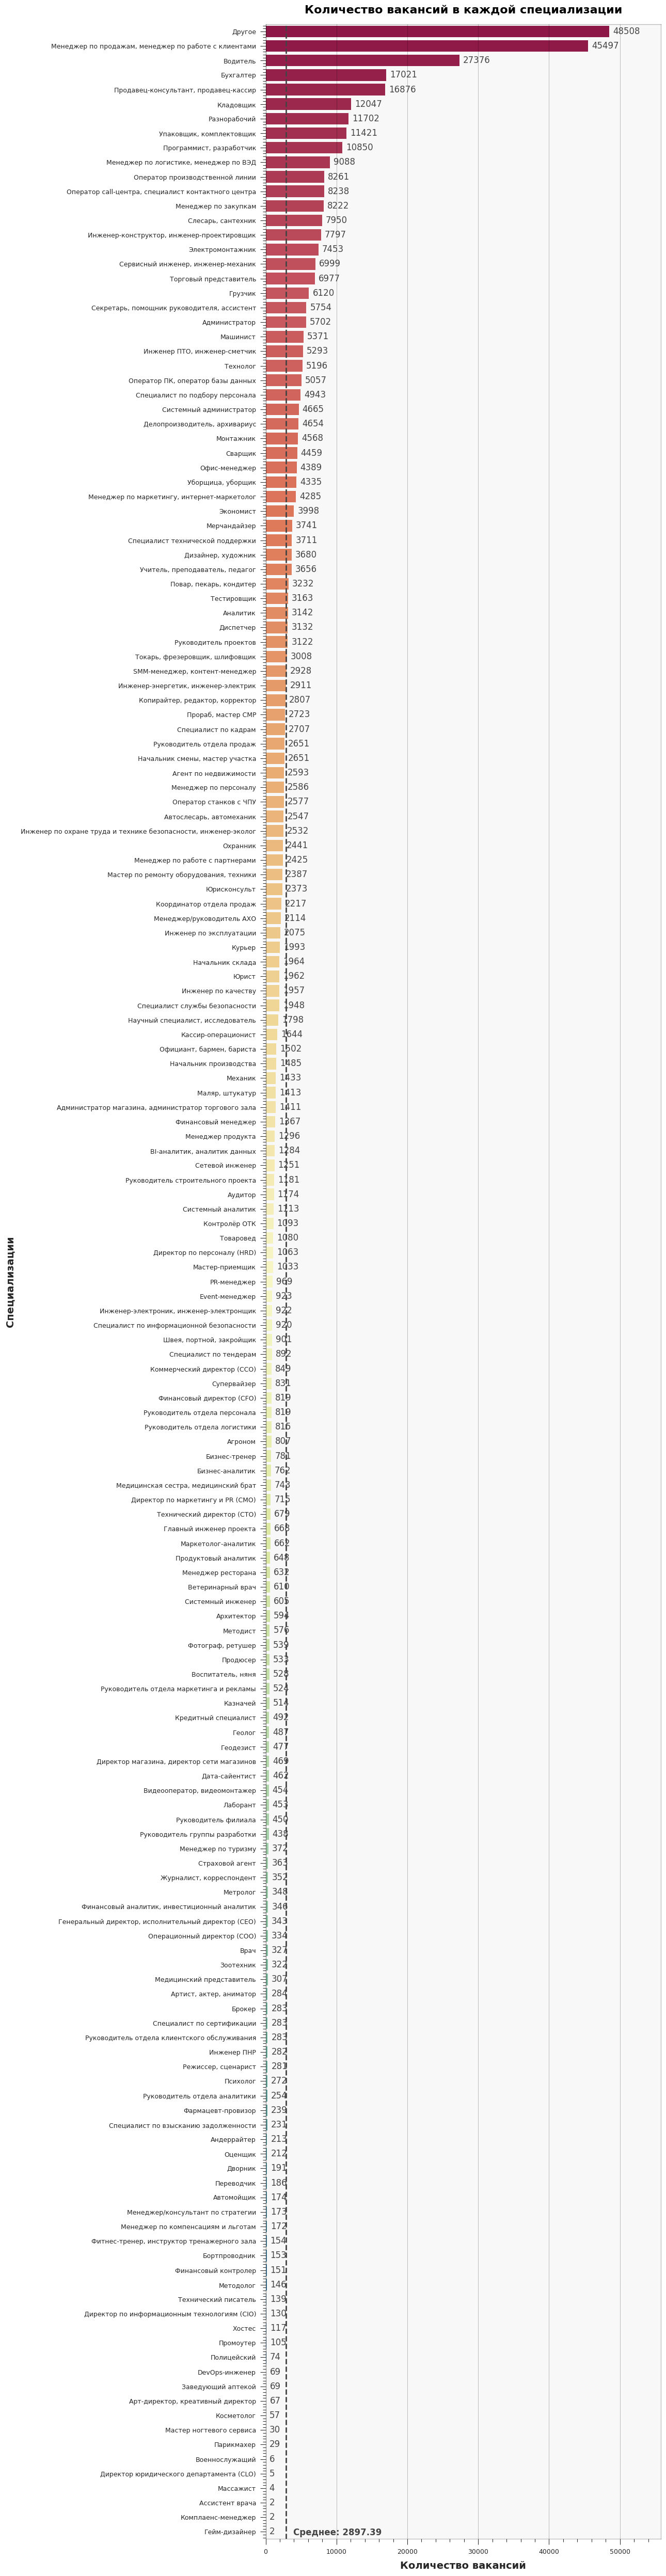

In [53]:
# Подсчет количества вакансий в каждой специализации и сортировка от большего к меньшему
sorted_data = df[columns[3]].value_counts().sort_values(ascending=False)

# Преобразование в DataFrame для использования в Seaborn
sorted_df = pd.DataFrame(sorted_data).reset_index()
sorted_df.columns = [columns[3], 'count']

# Визуализация
plt.figure(figsize=(13, 50))
ax = sns.barplot(y=columns[3], x='count', data=sorted_df, palette="Spectral")

# Определение максимального значения для оси X и добавление буфера
max_value = sorted_df['count'].max()
buffer = max_value * 0.15

# Устанавливаем диапазон оси X
ax.set_xlim(0, max_value + buffer)

# Добавляем числа справа от каждого столбца
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha="left", va="center", xytext=(5, 0), textcoords="offset points", fontsize=12, color="#444")

# Настройка заголовка и подписей
plt.title("Количество вакансий в каждой специализации", fontsize=16, fontweight="bold")
plt.xlabel("Количество вакансий", fontsize=14, fontweight="bold")
plt.ylabel("Специализации", fontsize=14, fontweight="bold")

# Добавление сетки
ax.xaxis.grid(True)  # Включение горизонтальной сетки

# Уменьшение отступов и улучшение размещения
plt.tight_layout()

# Добавление аннотации со средним значением
mean_value = sorted_df['count'].mean()
ax.axvline(mean_value, color="#444", linestyle="--", linewidth=2)
ax.annotate(f"Среднее: {mean_value:.2f}", xy=(mean_value, len(sorted_df) - 0.75), 
            xytext=(10, 0), textcoords="offset points", color="#444", fontsize=12, fontweight="bold", ha="left")

# Сохранение графика в высоком качестве
plt.savefig("vacancy_specializations.png", dpi=600, bbox_inches="tight", pad_inches=0.1)

# Отображение графика
plt.show()

In [50]:
unique_count = df['name'].nunique()

unique_count

8848

In [51]:
unique = df['name'].unique()

unique

array(['Инженер по наладке и испытаниям',
       'Менеджер отдела продаж с корпоративными клиентами',
       'Специалист по кадровому делопроизводству', ...,
       'Аналитик данных/Аналитик отдела продаж',
       'Ведущий инженер проекта', 'Бухгалтер - контролер (Крекшино)'],
      dtype=object)